In [13]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os

from torch.utils.data import Dataset
from PIL import Image
import os
import random
from torchvision import transforms

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc

from sklearn.preprocessing import label_binarize
from torch.nn.functional import softmax

import torch
from torchvision import models
import torch.nn as nn
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
import seaborn as sns

# Paths to VOC directories
base_dir = '/kaggle/input/pascal-voc-2012-dataset/VOC2012_test/VOC2012_test'
images_dir = os.path.join(base_dir, 'JPEGImages')
sets_dir = os.path.join(base_dir, 'ImageSets/Main')


In [2]:
# Function to read predefined splits
def get_files_from_split(file_path):
    with open(file_path, 'r') as f:
        files = [x.strip().split()[0] for x in f.readlines() if not x.startswith('#')]
    return files

class RotationDataset(Dataset):
    def __init__(self, file_list, root_dir, transform=None):
        """
        file_list: lista dei nomi dei file (es. ['2008_000001', ...])
        root_dir: cartella dove sono le immagini JPEG
        """
        self.file_list = file_list
        self.root_dir = root_dir
        self.transform = transform
        
        # Mappa le rotazioni in classi
        self.angle_to_label = {0: 0, 90: 1, 180: 2, 270: 3}

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        filename = self.file_list[idx]
        img_path = os.path.join(self.root_dir, filename + ".jpg")
        
        image = Image.open(img_path).convert("RGB")
        
        # 1. Scegliamo una rotazione casuale
        angle = random.choice([0, 90, 180, 270])
        
        # 2. Ruotiamo l'immagine
        # Nota: expand=True adatta la dimensione se l'img non è quadrata
        rotated_image = image.rotate(-angle, expand=True) 
        
        # 3. Creiamo la label per la rotazione
        label_rotation = self.angle_to_label[angle]
        
        # 4. Applichiamo le trasformazioni standard (Resize, ToTensor, Normalize)
        if self.transform:
            rotated_image = self.transform(rotated_image)
            
        return rotated_image, label_rotation

# Esempio di utilizzo
transform_pipeline = transforms.Compose([
    transforms.Resize(320),
    transforms.RandomResizedCrop(299),
    transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [4]:
# Get all files from test.txt
test_files = get_files_from_split(os.path.join(sets_dir, 'test.txt'))
np.random.shuffle(test_files)  # Shuffle to randomize the split

test_dataset = RotationDataset(test_files, images_dir, transform=transform_pipeline)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

test_loader = DataLoader(
    test_dataset,
    batch_size=128,
    shuffle=False
)

In [14]:
def evaluate_model(model, test_loader, class_names):

    y_preds = []
    y_labels = []
    y_probs = []

    misclassified_examples = []

    model.eval()
    with torch.no_grad():
        for x, y in test_loader:
            x = x.to(device)
            y = y.to(device)

            outputs = model(x)
            probs = softmax(outputs, dim=1)
            confs, preds = torch.max(probs, dim=1)

            # Store predictions
            y_preds.extend(preds.cpu().numpy())
            y_labels.extend(y.cpu().numpy())
            y_probs.extend(probs.cpu().numpy())

            # Store confident misclassifications
            for i in range(len(y)):
                if preds[i] != y[i]:
                    misclassified_examples.append({
                        "img": x[i].cpu(),
                        "true": y[i].item(),
                        "pred": preds[i].item(),
                        "conf": confs[i].item()
                    })

    # ---------------- Accuracy ----------------
    acc = accuracy_score(y_labels, y_preds)
    print(f"\nTest Accuracy: {acc:.4f}")

    # ---------------- Confusion Matrix ----------------
    cm = confusion_matrix(y_labels, y_preds)
    plt.figure(figsize=(6, 5))
    sns.heatmap(
        cm, annot=True, fmt='d', cmap='Blues',
        xticklabels=class_names,
        yticklabels=class_names
    )
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()

    # ---------------- Classification Report ----------------
    print("\nCLASSIFICATION REPORT")
    print(classification_report(
        y_labels,
        y_preds,
        target_names=class_names,
        digits=4
    ))

    # ---------------- ROC CURVES (One-vs-Rest) ----------------
    print("\nROC CURVES")

    num_classes = len(class_names)
    y_labels_bin = label_binarize(y_labels, classes=list(range(num_classes)))
    y_probs = np.array(y_probs)

    plt.figure(figsize=(7, 6))

    for i in range(num_classes):
        fpr, tpr, _ = roc_curve(y_labels_bin[:, i], y_probs[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f"{class_names[i]} (AUC = {roc_auc:.3f})")

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curves (One-vs-Rest)")
    plt.legend(loc="lower right")
    plt.grid(alpha=0.3)
    plt.show()

    # ---------------- TOP CONFIDENT FAILURES ----------------
    print("\n3. TOP CONFIDENT FAILURES (Visual Inspection)")
    print("These are images where the model was very confident but WRONG.")

    misclassified_examples.sort(key=lambda x: x["conf"], reverse=True)

    num_show = min(5, len(misclassified_examples))

    if num_show > 0:
        fig, axes = plt.subplots(1, num_show, figsize=(15, 4))
        if num_show == 1:
            axes = [axes]

        for i in range(num_show):
            data = misclassified_examples[i]

            # Un-normalize (ImageNet)
            img = data["img"].clone()
            mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
            std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
            img = img * std + mean
            img = torch.clamp(img, 0, 1)

            ax = axes[i]
            ax.imshow(img.permute(1, 2, 0).numpy())
            ax.axis("off")
            ax.set_title(
                f"True: {class_names[data['true']]}\n"
                f"Pred: {class_names[data['pred']]}\n"
                f"Conf: {data['conf']:.2f}",
                color="red",
                fontsize=10
            )

        plt.show()
    else:
        print("No errors found! (100% Accuracy)")


Test Accuracy: 0.7170


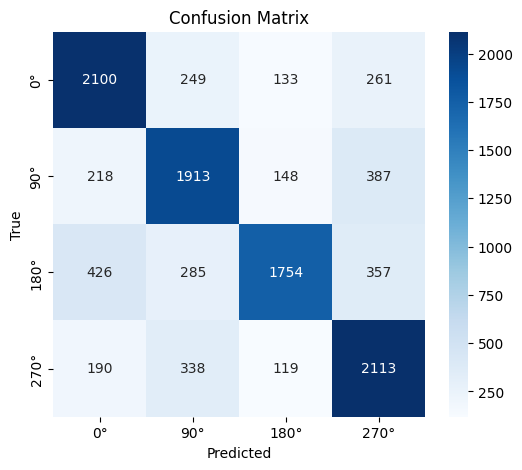


CLASSIFICATION REPORT
              precision    recall  f1-score   support

          0°     0.7157    0.7656    0.7398      2743
         90°     0.6869    0.7176    0.7019      2666
        180°     0.8143    0.6215    0.7050      2822
        270°     0.6777    0.7656    0.7190      2760

    accuracy                         0.7170     10991
   macro avg     0.7237    0.7176    0.7164     10991
weighted avg     0.7245    0.7170    0.7164     10991


ROC CURVES


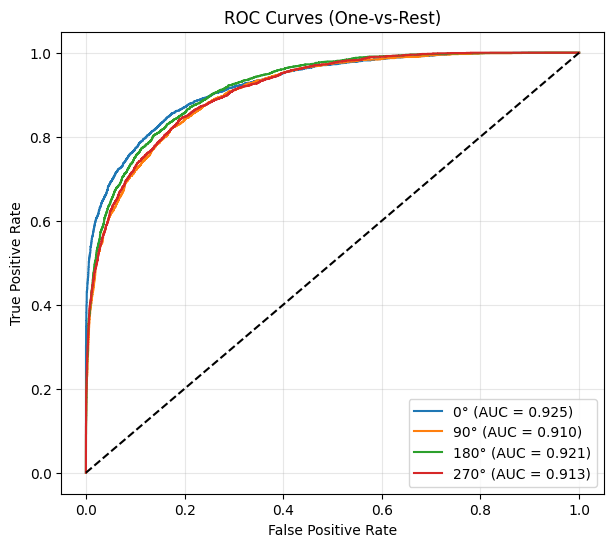


3. TOP CONFIDENT FAILURES (Visual Inspection)
These are images where the model was very confident but WRONG.


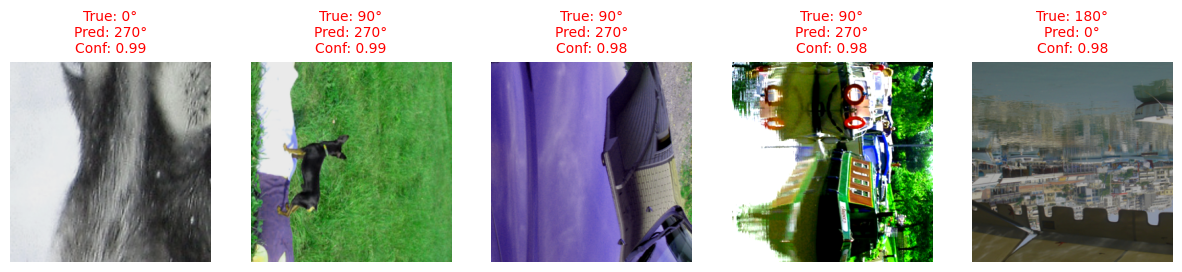


Test Accuracy: 0.5807


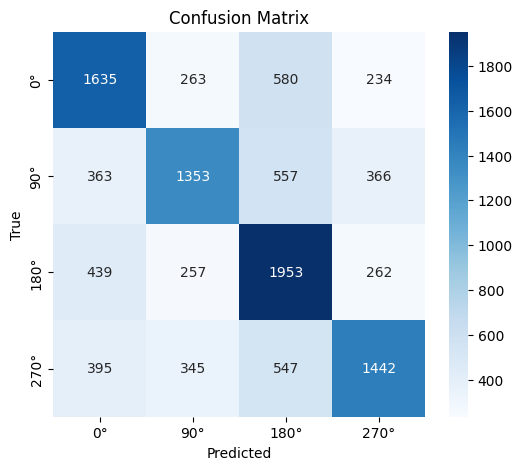


CLASSIFICATION REPORT
              precision    recall  f1-score   support

          0°     0.5773    0.6029    0.5898      2712
         90°     0.6100    0.5127    0.5571      2639
        180°     0.5370    0.6709    0.5965      2911
        270°     0.6259    0.5284    0.5730      2729

    accuracy                         0.5807     10991
   macro avg     0.5875    0.5787    0.5791     10991
weighted avg     0.5865    0.5807    0.5796     10991


ROC CURVES


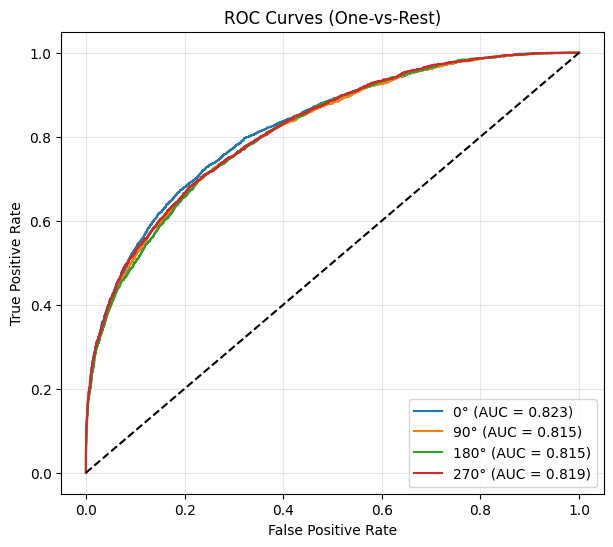


3. TOP CONFIDENT FAILURES (Visual Inspection)
These are images where the model was very confident but WRONG.


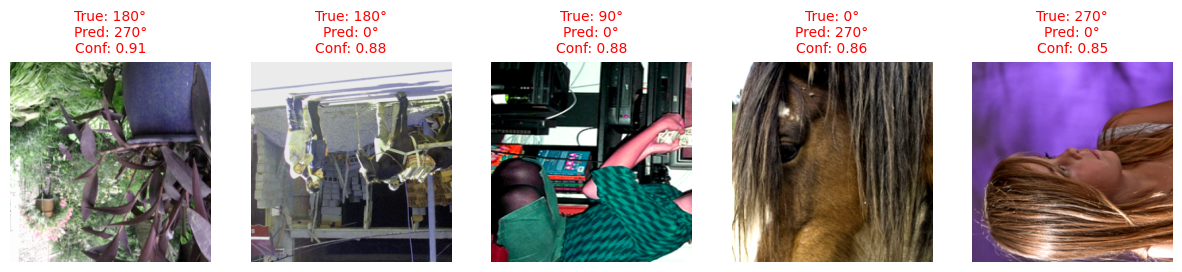

In [15]:
# Define class names (based on your rotation angles)
class_names = ['0°', '90°', '180°', '270°']

model = models.efficientnet_b0(num_classes=4)
model.load_state_dict(torch.load("/kaggle/input/modelb0/pytorch/default/1/EfficientNetB0.pth", map_location=device))
model.to(device)

evaluate_model(model, test_loader, class_names)

2 devices

Test Accuracy: 0.6408


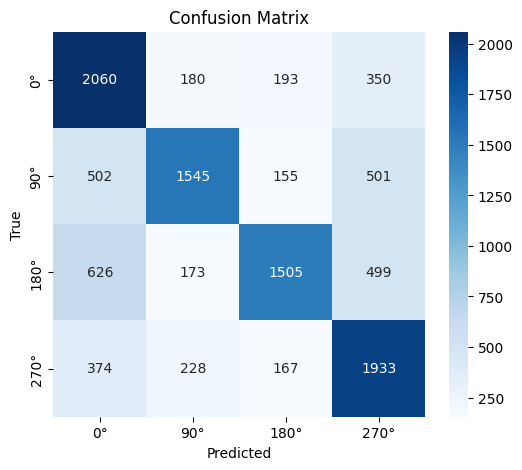


CLASSIFICATION REPORT
              precision    recall  f1-score   support

          0°     0.5783    0.7402    0.6493      2783
         90°     0.7267    0.5716    0.6399      2703
        180°     0.7450    0.5369    0.6241      2803
        270°     0.5888    0.7154    0.6459      2702

    accuracy                         0.6408     10991
   macro avg     0.6597    0.6410    0.6398     10991
weighted avg     0.6599    0.6408    0.6397     10991


ROC CURVES


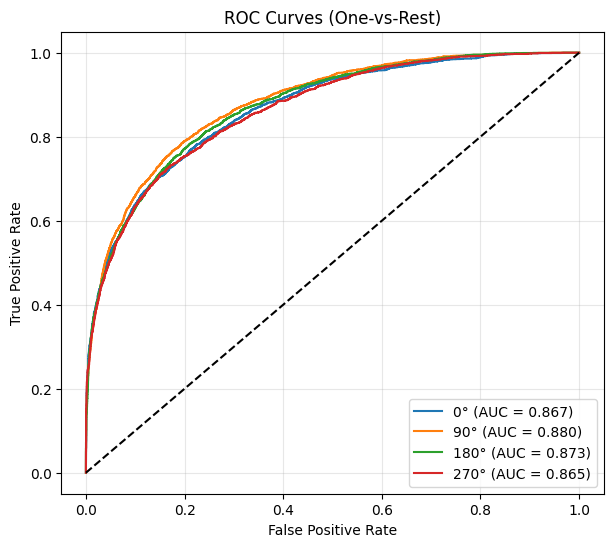


3. TOP CONFIDENT FAILURES (Visual Inspection)
These are images where the model was very confident but WRONG.


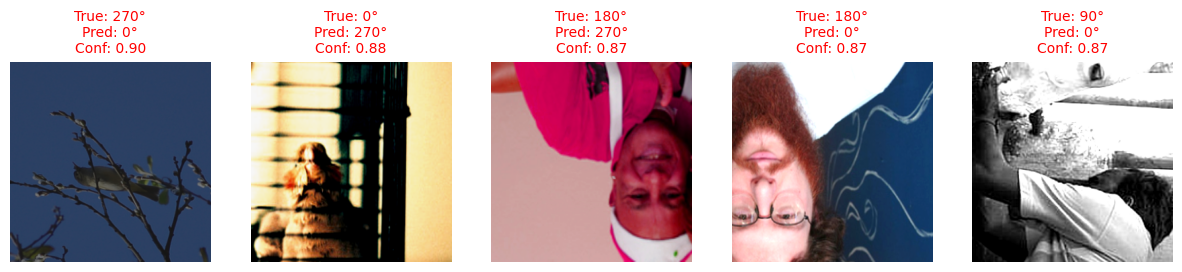

In [18]:
model = models.resnet50(weights=None)

num_ftrs = model.fc.in_features
model.fc = nn.Sequential(
    nn.Linear(num_ftrs, num_ftrs),  # Hidden layer (maintains size or reduces)
    nn.ReLU(),                      # Non-linearity (Crucial!)
    nn.Linear(num_ftrs, 4)          # Output layer
)

model.load_state_dict(torch.load("/kaggle/input/resnet50fut/pytorch/default/1/fullTraining_resnet50.pth", map_location=device))

if torch.cuda.device_count() > 1:
    model = nn.DataParallel(model)
    print(torch.cuda.device_count(), "devices")

model.to(device)

evaluate_model(model, test_loader, class_names)

In [ ]:
model = models.efficientnet_b3(num_classes=4)
model.load_state_dict(torch.load("/kaggle/input/efficientnetb3fut/pytorch/default/1/full_training_EfficientNetB3.pth", map_location=device))
model.to(device)

evaluate_model(model, test_loader, class_names)